## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import read_image

from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from PIL import Image
from tqdm import tqdm

%matplotlib inline

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [15]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

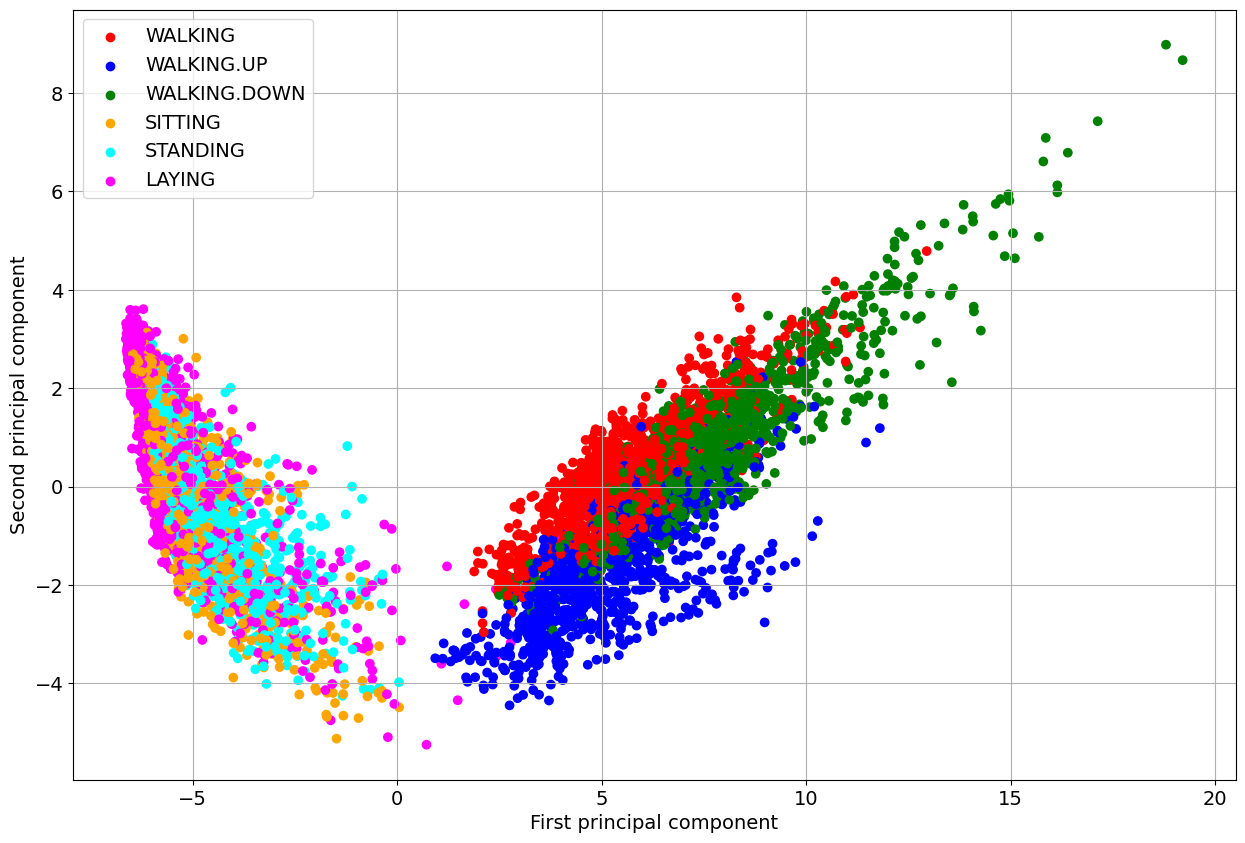

In [16]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [18]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [19]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

Для реализации данной задачи была использована LSTM сеть из предыдущей задачи.
Пришлось ее немного пофиксить и потюнить, чтобы дала необходимый результат.
Более простая RNN с задачей с нужной точность, к сожалению, не справилась.

In [22]:
dataset = TensorDataset(torch.Tensor(X_train),
                        F.one_hot(torch.LongTensor(y_train).squeeze(-1), n_classes).float())
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([256, 128, 9]) torch.Size([256, 6])


In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size=9, hidden_size=32, layers=2):
        super(self.__class__, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True).to(device)
        self.classification = nn.Sequential(nn.Linear(128 * 32, 6),
                                            nn.ReLU(),
                                            nn.Softmax(-1)).to(device)

    def forward(self, x):
        h_seq, _ = self.lstm(x)
        output = self.classification(h_seq.reshape(x.shape[0], -1))
        return output

In [25]:
def train_loop(model, loss_func, opt, n_epoch, train_loader, train_loss, train_accuracy):
    for _ in tqdm(range(n_epoch)):
        epoch_loss = []
        epoch_accuracy = []
        for x_batch, y_batch in train_loader:
            predictions = model(x_batch.to(device))

            loss = loss_func(predictions, y_batch.to(device))

            loss.backward()
            opt.step()
            opt.zero_grad()

            epoch_loss.append(loss.item())

            predictions = predictions.argmax(dim=-1).cpu().numpy()
            y_batch = y_batch.argmax(dim=-1).cpu().numpy()
            epoch_accuracy.append(accuracy_score(predictions, y_batch))

        train_loss.append(sum(epoch_loss) / len(epoch_loss))
        train_accuracy.append(sum(epoch_accuracy) / len(epoch_accuracy))
    print('Train Loss:', train_loss[-1])

In [26]:
model = LSTM()
opt = torch.optim.Adam(model.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()
n_epoch = 500
train_loss = []
train_accuracy = []

train_loop(
    model=model,
    loss_func=loss_func,
    opt=opt,
    n_epoch=n_epoch,
    train_loader=train_loader,
    train_loss = train_loss,
    train_accuracy=train_accuracy
)

100%|██████████| 500/500 [02:47<00:00,  2.98it/s]

Train Loss: 1.0650682367127517


In [27]:
def plot_accuracy(train_loss, label='Train Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title('Accuracy')
    plt.plot(np.array(train_loss), label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.75, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_loss(train_loss):
    plt.figure(figsize=(10, 6))
    plt.title('Loss')
    plt.plot(np.array(train_loss), label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()


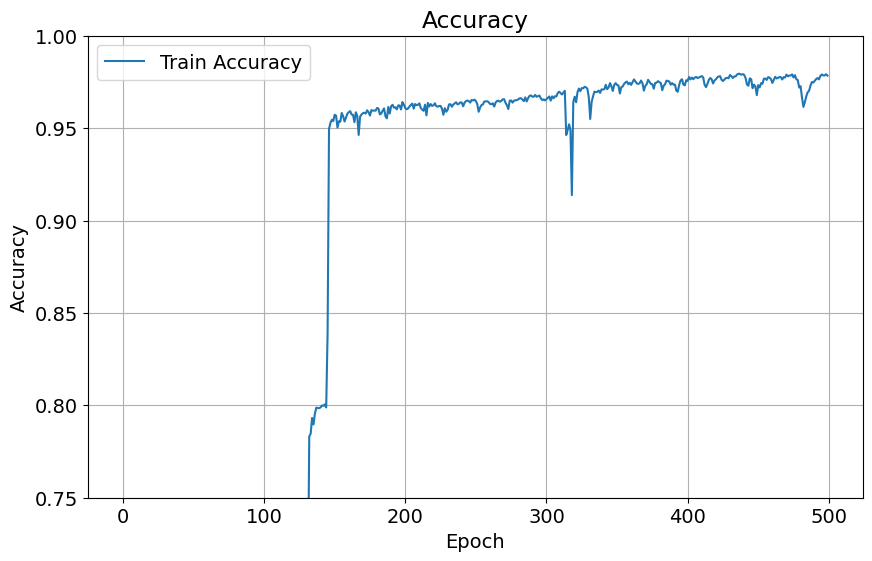

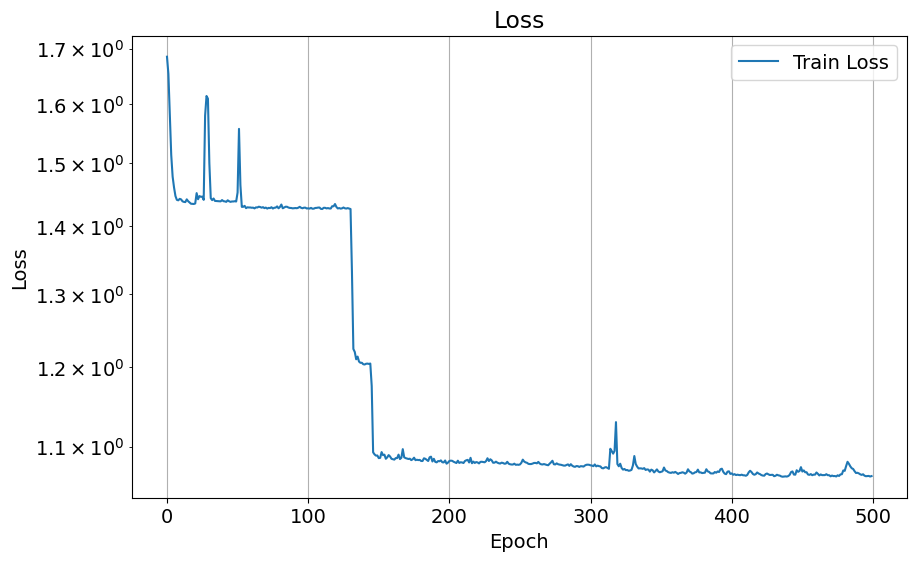

In [28]:
plot_accuracy(train_accuracy)
plot_loss(train_loss)

In [29]:
model.eval()
with torch.no_grad():
    output = model(torch.Tensor(X_test).to(device))
    predictions = output.argmax(-1).detach().cpu().numpy()
    print(accuracy_score(predictions, y_test))

0.9189005768578216


**Вывод:**
Реализация LSTM из предыдущей работы с небольшим тюнингом и подбором параметров вполне справилас с решением с необходимой точностью > 91%.
Для этого нам понадобилось 500 эпох, функция потерь CrossEntropyLoss и оптимизатор Adam с lr=0.002

Accuracy: 0.9189


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

Для реализации данной задачи будем использовать траснформер изобажений и предобученную сеть Resnet152.

In [34]:
import torch
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [56]:
n_classes = 50

transformer = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.CenterCrop((220, 220)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(root='./data/train/', transform=transformer)

In [57]:
train_idx, valid_idx= train_test_split(np.arange(len(train_dataset.targets)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=train_dataset.targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, sampler=valid_sampler)

Технический слот, почистим память ГПУ:

In [58]:
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

7367

Загрузим предобученную модель Resnet152 и заморозим слои, чтобы не переобучать всю модель. Также добавим слой между разблокированным последним слоем модели и нашим слоем:

In [59]:
from torchvision.models import ResNet152_Weights

model_resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
for param in model_resnet.parameters():
    param.requires_grad = False

num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, n_classes)
model_resnet = model_resnet.cuda()
print(model_resnet.fc.in_features, n_classes)

2048 50


Добавим функцию обучения. Она практически идентична многим другим, реализованных в данной лабораторной работе:

In [60]:

def train_loop(model, loss_func, opt, n_epoch, train_loader, train_loss, test_accuracy):
    for _ in tqdm(range(n_epoch)):
        epoch_loss = []
        for x_batch, y_batch in train_loader:
            predictions = model(x_batch.to(device))

            loss = loss_func(predictions, y_batch.to(device))

            loss.backward()
            opt.step()
            opt.zero_grad()

            epoch_loss.append(loss.item())

        train_loss.append(sum(epoch_loss) / len(epoch_loss))

        epoch_accuracy = []
        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_loader:
                output = model(torch.Tensor(x_val).to(device))
                predictions = output.argmax(-1).detach().cpu().numpy()
                epoch_accuracy.append(accuracy_score(predictions, y_val))
        test_accuracy.append(sum(epoch_accuracy) / len(epoch_accuracy))

    print('Train Loss: ', train_loss[-1])
    print('Test Accuracy: ', test_accuracy[-1])

Зададим параметры обучения:
Будем использовать Adam и CrossEntropyLoss

In [61]:
model_resnet.to(device)
opt = torch.optim.Adam(model_resnet.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
n_epoch = 10

train_loss = []
test_accuracy = []

train_loop(
    model=model_resnet,
    loss_func=loss_func,
    opt=opt,
    n_epoch=n_epoch,
    train_loader=train_loader,
    train_loss=train_loss,
    test_accuracy=test_accuracy
)


100%|██████████| 10/10 [07:29<00:00, 44.99s/it]

Train Loss: 0.2237903998233378
Test Accuracy: 0.9477777777777774


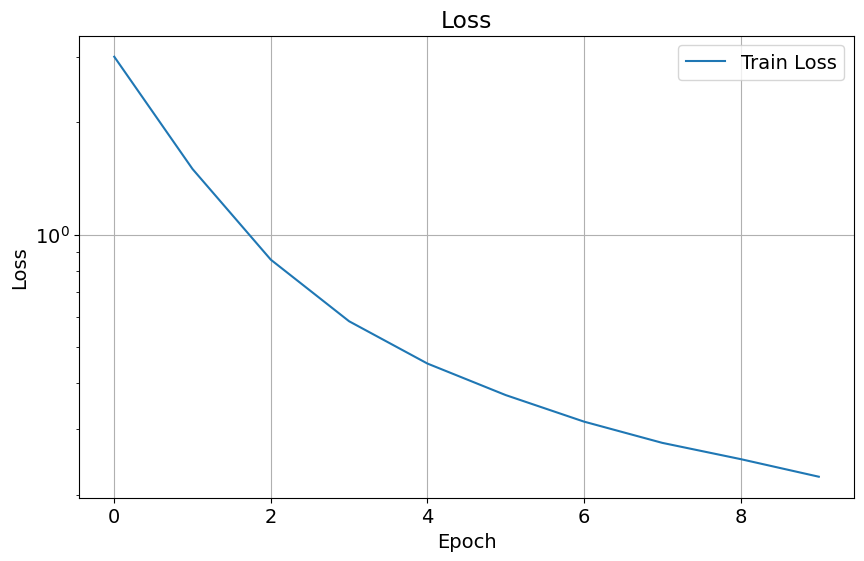

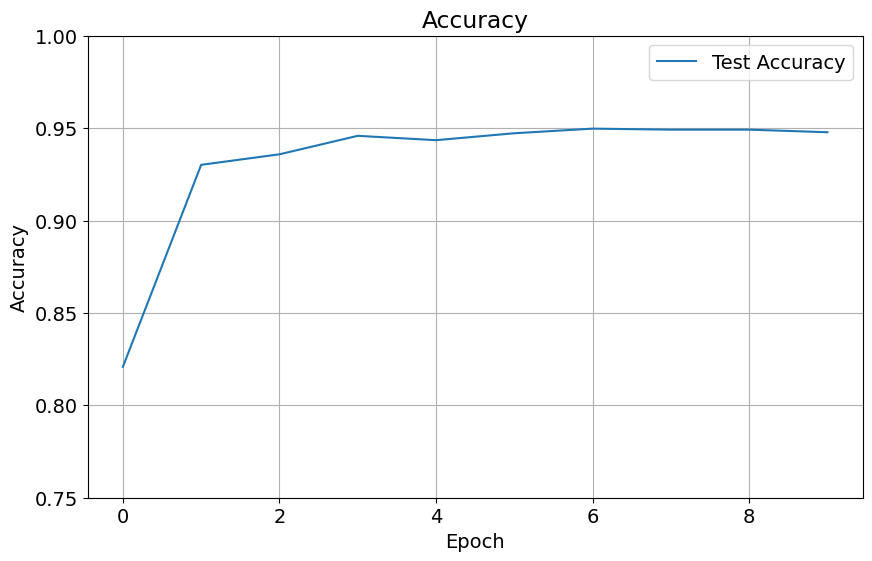

In [62]:
plot_loss(train_loss)
plot_accuracy(test_accuracy, label='Test Accuracy')

В результате дообучения resnet152 получили вполне неплохие результаты:

Train Loss: 0.2237903998233378
Test Accuracy: 0.9477777777777774

С точностью на тесте более >94%

Далее для формирования сабмит файла с предсказаниями необходимо проделать некоторые манипуляции, чтобы сформировать корректный датасет для предсказания.

Создаем CustomDataset из списка файлов. Кастомизировал custom dataset под требования задачи для последующего получения предиктов:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [64]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        # image = read_image(img_path)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image


Далее сортируем правильно названия файлов, чтобы они шли по численному порядку, те 1.jpeg,2.jpeg,3.jpeg,...,10.jpeg,11.jpeg,12.jpeg,...,501.jpeg,502.jpeg,503.jpeg и тд

In [65]:
test_path = './data/test/'
files_names = sorted(os.listdir(test_path), key=lambda x: int(''.join(filter(str.isdigit, x))))
files = [test_path+file for file in files_names]

custom_dataset = CustomImageDataset(files, transform=transformer)
test_data_loader = DataLoader(custom_dataset)

Формируем цикл предсказываний и отправляем в my_submission.csv:

In [66]:
results = []
model_resnet.eval()
with torch.no_grad():
    for x_test in test_data_loader:
        output = model_resnet(torch.Tensor(x_test).to(device))
        predictions = output.argmax(-1).detach().cpu().numpy()
        results.extend(predictions)

df =  pd.DataFrame(list(zip(files_names, results)), columns=['Name', 'Class'])
df.to_csv('my_submission.csv', header=True, index=False)


Вводы:
Задание выполнено с точностью на тесте более >94%.
В качестве сети использовалась ResNet152
В качестве опытов использовались ResNet50 и ResNet102, а также попытка использовать vit_b_16.
Но они в целом показали себя или хуже по конечной точности или занимали больше вычислительных ресурсов.

В целом занимательная задача получилась, разный формат изображений заставил подбирать параметры трансформера с кропом и ресайзом изображений.
Без этого хороший результать было получить очень сложно.